## Sentiment analysis

### Step 1: Prepare the data

In [32]:
import pandas as pd

In [33]:
reviews_df = pd.read_csv('../02.Dataset/labeled/reviews.csv')

In [34]:
reviews_df.head()

,ProductID,CustomerID,Rating,Comment,Label
0,74021317,7991785,5,Một quyển sách hay,pos
1,187827003,18150739,5,"Mình đã từng đọc sơ nội dung sách, rất hay, rấ...",pos
2,271380890,497788,5,"Quyển sách đẹp về hình thức, nội dung mới đọc ...",pos
3,74021317,19165924,5,"Sách đẹp, hài lòng",pos
4,105483727,10170816,5,"sách đóng gói cẩn thận, giao hành nhanh",pos


In [35]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ProductID   4380 non-null   int64 
 1   CustomerID  4380 non-null   int64 
 2   Rating      4380 non-null   int64 
 3   Comment     4380 non-null   object
 4   Label       4380 non-null   object
dtypes: int64(3), object(2)
memory usage: 171.2+ KB


In [36]:
reviews_df["Label"].value_counts()

Label
neg    2101
pos    1923
neu     356
Name: count, dtype: int64

In [37]:
reviews_df = reviews_df[reviews_df['Label'] != 'neu'].copy()

In [38]:
reviews_df.dropna(inplace=True)

In [39]:
print(reviews_df["Label"].unique())

['pos' 'neg']


In [40]:
reviews_df["Label"].value_counts()

Label
neg    2101
pos    1923
Name: count, dtype: int64

### Step 2: Data preprocessing

In [ ]:
CUSTOM_RULES = {
    # Giao hàng, dịch vụ
    "giao hàng": "giao_hàng",
    "giao hành": "giao_hàng",
    "giao hàng nhanh": "giao_hàng_nhanh",
    "giao hành nhanh": "giao_hàng_nhanh",
    "đóng gói": "đóng_gói",
    "cẩn thận": "cẩn_thận",
    "chuyển phát": "chuyển_phát",
    "nhân viên": "nhân_viên",
    "dịch vụ": "dịch_vụ",
    "đặt hàng": "đặt_hàng",
    "hàng hóa": "hàng_hóa",
    "thời gian": "thời_gian",
    "màng co": "màng_co",
    # Sách và nội dung
    "sách mới": "sách_mới",
    "sách hay": "sách_hay",
    "nội dung": "nội_dung",
    "kiến thức": "kiến_thức",
    "bài học": "bài_học",
    "tư duy": "tư_duy",
    "văn phong": "văn_phong",
    "truyện ngắn": "truyện_ngắn",
    "tiểu thuyết": "tiểu_thuyết",
    "sách thiếu nhi": "sách_thiếu_nhi",
    "sách kỹ năng": "sách_kỹ_năng",
    "sách giáo khoa": "sách_giáo_khoa",
    "truyện tranh": "truyện_tranh",
    "lịch sử": "lịch_sử",
    "sản phẩm": "sản_phẩm",
    # Cảm nhận và đánh giá
    "rất hay": "rất_hay",
    "rất tốt": "rất_tốt",
    "dễ hiểu": "dễ_hiểu",
    "đáng mua": "đáng_mua",
    "giá cả": "giá_cả",
    "chất lượng": "chất_lượng",
    "đúng mô tả": "đúng_mô_tả",
    "không hay": "bình thường",
    "trải nghiệm": "trải_nghiệm",
    "bao bọc": "bao_bọc",
    "nên đọc": "nên_đọc",
    "không cẩn thận": "không_cẩn_thận",
    "thấm nước": "thấm_nước",
    "góc nhìn": "góc_nhìn",
    "quyển sách": "quyển_sách",
    "đơn hàng": "đơn_hàng",
    "đáng tiền": "đáng_tiền",
    "không nhăn": "không_nhăn",
    "chống sốc": "chống_sốc",
    "đáng đọc": "đáng_đọc",
    "không có gì là hay": "không_hay",
    "không có hay": "không_hay",
    "không có gì hay": "không_hay",
    "phỏng tác": "phỏng_tác",
    "tạm ổn": "tạm_ổn",
    "chưa ổn": "chưa_ổn",
    "trang": "trang_sách"
}

In [42]:
import csv
import string
import emoji
import re
from pyvi import ViTokenizer
import pandas as pd


# Clean icons
def clean_icons(text):
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"[:;][-~]?[)D(/\\|pP]", "", text)
    text = text.replace("_x000D_", " ")
    return text


def lower(text):
    return text.lower().strip()


def remove_links(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)


def remove_punctuation(text):
    return text.translate(str.maketrans({p: "" for p in string.punctuation}))


dictionary = {}
with open(
    "../02.Dataset/teencode.csv",
    mode="r",
    encoding="utf-8",
) as file:
    reader = csv.DictReader(file)
    for row in reader:
        dictionary[row["Teencode"]] = row["Meaning"]


# Convert comment to a full sentence
def convert_teencode_to_vietnamese(sentence):
    words = sentence.split()
    converted_words = []
    for word in words:
        if word in dictionary:
            converted_words.append(dictionary[word])
            continue

        punctuation = ""
        temp_word = word
        while temp_word and temp_word[-1] in string.punctuation:
            punctuation = temp_word[-1] + punctuation
            temp_word = temp_word[:-1]
        if temp_word in dictionary:
            converted_words.append(dictionary[temp_word] + punctuation)
            continue

        leading_punctuation = ""
        temp_word = word
        while temp_word and temp_word[0] in string.punctuation:
            leading_punctuation += temp_word[0]
            temp_word = temp_word[1:]
        if temp_word in dictionary:
            converted_words.append(leading_punctuation + dictionary[temp_word])
            continue

        converted_words.append(word)

    return " ".join(converted_words)


# Remove stopwords
with open("../02.Dataset/vietnamese-stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = set(line.strip().lower() for line in f if line.strip())


def remove_vietnamese_stopwords(text):
    words = text.split()
    result = []
    i = 0
    while i < len(words):
        if i < len(words) - 1:
            two_word = f"{words[i]}_{words[i+1]}"
            if two_word in stopwords:
                i += 2
                continue
        if words[i] not in stopwords:
            result.append(words[i])
        i += 1
    return " ".join(result)


def word_tokenize(text):
    if pd.isna(text):
        return ""
    for k, v in sorted(CUSTOM_RULES.items(), key=lambda x: len(x[0]), reverse=True):
        # print(f'{k}: {v}')
        text = text.replace(k, v)
    return ViTokenizer.tokenize(text)
  

In [43]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = clean_icons(text)
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_links(text)
    text = convert_teencode_to_vietnamese(text)
    text = word_tokenize(text)
    text = remove_vietnamese_stopwords(text)
    return text

In [44]:
sentence = "Trời hôm nay nóng quá! Vấn đề là mình không đem theo áo khoác! Tóm lại là trời nắng! Chất lượng sách tốt! Giao hàng nhanh! Sách bọc cẩn thận!"
print(preprocess_text(sentence))
# sentence = lower(sentence)
# sentence = remove_punctuation(sentence)
# sentence = word_segmentation(sentence)
# print(sentence)
# sentence = remove_vietnamese_stopwords(sentence)
# print(sentence)

hôm_nay nóng không đem áo_khoác nắng chất_lượng sách giao_hàng_nhanh sách bọc cẩn_thận


In [45]:
print(preprocess_text("Sách hay quá"))
print(preprocess_text("Sách dở quá"))
print(preprocess_text("Sách bình thường"))
print(preprocess_text("Sách không hay lắm"))
print(preprocess_text("Sách dính các trang vào nhau"))
print(preprocess_text("Đã nhận hơi trễ !"))
print(preprocess_text("Sách bọc cẩn thận"))
print(preprocess_text("Sách phù hợp"))
print(preprocess_text("Sách mới và bao bọc cẩn thận"))

sách_hay
sách dở
sách bình_thường
sách bình_thường
sách dính trang sách
nhận hơi trễ
sách bọc cẩn_thận
sách phù_hợp
sách_mới bao_bọc cẩn_thận


In [46]:
# reviews_df["Comment"] = reviews_df["Comment"].apply(lower)
# reviews_df["Comment"] = reviews_df["Comment"].apply(clean_icons)
# reviews_df["Comment"] = reviews_df["Comment"].apply(remove_punctuation)
# reviews_df["Comment"] = reviews_df["Comment"].apply(remove_links)
# reviews_df["Comment"] = reviews_df["Comment"].apply(word_segmentation)
# reviews_df["Comment"] = reviews_df["Comment"].apply(convert_teencode_to_vietnamese)
# reviews_df["Comment"] = reviews_df["Comment"].apply(remove_vietnamese_stopwords)

reviews_df["Comment Cleaned"] = reviews_df["Comment"].apply(preprocess_text)

reviews_df.dropna(subset=["Comment Cleaned"], inplace=True)

reviews_df.reset_index(drop=True, inplace=True)

In [47]:
# # Word segmentation
# from underthesea import word_tokenize

# text = "Sản phẩm rất tốt và giao hàng nhanh"
# print(word_tokenize(text))

In [48]:
reviews_df.head(100)

,ProductID,CustomerID,Rating,Comment,Label,Comment Cleaned
0,74021317,7991785,5,Một quyển sách hay,pos,quyển_sách_hay
1,187827003,18150739,5,"Mình đã từng đọc sơ nội dung sách, rất hay, rấ...",pos,đọc sơ nội_dung sách rất_hay đáng nghiền_ngẫm ...
2,271380890,497788,5,"Quyển sách đẹp về hình thức, nội dung mới đọc ...",pos,quyển_sách đẹp hình_thức nội_dung mới đọc tò_m...
3,74021317,19165924,5,"Sách đẹp, hài lòng",pos,sách đẹp hài_lòng
4,105483727,10170816,5,"sách đóng gói cẩn thận, giao hành nhanh",pos,sách đóng_gói cẩn_thận giao_hàng_nhanh
...,...,...,...,...,...,...
95,136340700,16493140,5,"Đặt sau 1 tiếng có hàng r, quá nhanh quá yêu, ...",pos,1 tiếng hàng nhanh yêu đánh_giá nội_dung
96,54614797,10456907,5,"Bìa đẹp, giao hàng siêu nhanh, đóng gói cẩn thận",pos,bìa đẹp giao_hàng nhanh đóng_gói cẩn_thận
97,113530805,18051370,5,sách viết về các trải nghiệm của tác giả. 1 cu...,pos,sách viết trải_nghiệm tác_giả 1 sách trẻ nên_đọc
98,8886007,16290383,5,"Ngay sau khi đọc xong Người đua diều, mk đã mu...",pos,đọc xong người đua diều mua sách bề_ngoài chê


In [49]:
reviews_df.to_csv('../02.Dataset/reviews_cleaned.csv')

In [50]:
ids = []
for idx, productId, customerId, rating, comment, label, commentCleaned in reviews_df.itertuples():
    if commentCleaned == "giao_hàng":
      ids.append(idx)

In [51]:
for idx, productId, customerId, rating, comment, label, commentCleaned in reviews_df.itertuples():
    if idx in ids:
      print(comment)

### Step 3: Split the dataset to train set and test set

In [52]:
from sklearn.model_selection import train_test_split


X = reviews_df["Comment Cleaned"]

y = reviews_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [53]:
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("---------------------------")
print("y_train:\n", y_train)
print("y_test:\n", y_test)

X_train:
 2665    sách giao hộp rách sách gãy góc hơi buồn mua o...
3740                        góc sách vận_chuyển quăn trơn
2138    truyện hay xúc_động bé tâm_hồn nhạy_cảm_khao y...
1419    đẹp shipper thân_thiện tiki trading rẻ đóng_gó...
283                                              hài_lòng
                              ...                        
1130    đóng_gói hơi lỏng_lẻo nên sách móp gáy nhẹ may...
1294                   sách đẹp nội_dung hấp_dẫn cuốn_hút
860                     giao_hàng_nhanh đóng_gói cẩn_thận
3507    mua cảm_giác ném tiền nội_dung chán chút hữu_í...
3174                                 sợ tiki đánh_giá lun
Name: Comment Cleaned, Length: 3219, dtype: object
X_test:
 1718    giao_hàng_nhanh sách mấy trang sách quăn góc b...
1204    sách đẹp chỗ hằn dấu bìa hình chất_lượng mặt t...
2722    sách viết tác_giả thiếu chuyên_môn tham_gia ho...
1937                                        giao_hàng lâu
1226    sách sản_phẩm quảng_cáo xử_lí đơn_hàng lâu chố...
  

### Step 4: Train and fit the model

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
from sklearn.svm import LinearSVC
text_clf_svm = Pipeline([("tfidf", TfidfVectorizer(max_features=3000, min_df=5, max_df=0.8, sublinear_tf=True)), ("clf", LinearSVC())])
text_clf_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=5,
                                 sublinear_tf=True)),
                ('clf', LinearSVC())])

In [56]:
from sklearn.linear_model import LogisticRegression
text_clf_log = Pipeline([("tfidf", TfidfVectorizer(max_features=3000, min_df=5, max_df=0.8, sublinear_tf=True)), ("clf", LogisticRegression())])
text_clf_log.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=5,
                                 sublinear_tf=True)),
                ('clf', LogisticRegression())])

### Step 5: Run predictions and analyze the results

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions_svm = text_clf_svm.predict(X_test)

print("-----------------SVM-----------------")
print("Confusion matrix:\n", confusion_matrix(y_test, predictions_svm))
print()
print(f"Accuracy score: {accuracy_score(y_test, predictions_svm)}")
print()
print("Classification report:\n", classification_report(y_test, predictions_svm))

-----------------SVM-----------------
Confusion matrix:
 [[379  29]
 [ 46 351]]

Accuracy score: 0.906832298136646

Classification report:
               precision    recall  f1-score   support

         neg       0.89      0.93      0.91       408
         pos       0.92      0.88      0.90       397

    accuracy                           0.91       805
   macro avg       0.91      0.91      0.91       805
weighted avg       0.91      0.91      0.91       805



In [58]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions_log = text_clf_log.predict(X_test)

print("-----------------LogisticRegression-----------------")
print("Confusion matrix:\n", confusion_matrix(y_test, predictions_log))
print()
print(f"Accuracy score: {accuracy_score(y_test, predictions_log)}")
print()
print("Classification report:\n", classification_report(y_test, predictions_log))

-----------------LogisticRegression-----------------
Confusion matrix:
 [[381  27]
 [ 51 346]]

Accuracy score: 0.9031055900621118

Classification report:
               precision    recall  f1-score   support

         neg       0.88      0.93      0.91       408
         pos       0.93      0.87      0.90       397

    accuracy                           0.90       805
   macro avg       0.90      0.90      0.90       805
weighted avg       0.90      0.90      0.90       805



In [59]:
text_clf_log.predict(["Sách hay quá", "Sách dở quá", "Sách bình thường", "Sách không hay lắm", "Sách dính các trang vào nhau", "Đã nhận hơi trễ !"])

array(['pos', 'neg', 'pos', 'pos', 'neg', 'neg'], dtype=object)

### Step 6: Save the model

In [60]:
# %pip install joblib

In [61]:
import joblib

In [62]:
import datetime

joblib.dump(text_clf_svm, f"../05.Models/text_clf_svm_{datetime.datetime.now().strftime('%Y%m%d')}.pkl")
# joblib.dump(text_clf_log, f"../05.Models/text_clf_log.pkl")

['../05.Models/text_clf_svm_20250510.pkl']

## Adjust ratings

In [1653]:
import joblib

text_clf_svm = joblib.load("../05.Models/text_clf_svm_20250507.pkl")

In [1654]:

text_clf_svm.predict(
    [
        preprocess_text("Sách hay quá"),
        preprocess_text("Sách dở quá"),
        preprocess_text("Sách bình thường"),
        preprocess_text("Sách không hay lắm"),
        preprocess_text("Sách dính các trang vào nhau"),
        preprocess_text("Đã nhận hơi trễ !"),
        preprocess_text("Sách mới và được bọc cẩn thận"),
        preprocess_text("Sách mới và bao bọc cẩn thận"),
        preprocess_text("giao hàng chậm như 1 con rùa")
    ]
)

array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg'],
      dtype=object)

In [1655]:
import pandas as pd
reviews_df = pd.read_csv('../02.Dataset/reviews_300k.csv') 

In [1656]:
print(f"Total number of reviews: {len(reviews_df)}")

Total number of reviews: 296836


In [1657]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296836 entries, 0 to 296835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     296836 non-null  int64 
 1   productId  296836 non-null  int64 
 2   rating     296836 non-null  int64 
 3   comment    99520 non-null   object
dtypes: int64(3), object(1)
memory usage: 9.1+ MB


In [1658]:
reviews_filtered = reviews_df.groupby("userId").filter(lambda x: len(x) > 3)

In [1659]:
print(f'Total number of reviews filtered: {len(reviews_filtered)}')

Total number of reviews filtered: 73271


In [1660]:
reviews_no_comment = reviews_filtered[reviews_filtered["comment"].isna()].copy()
reviews_with_comment = reviews_filtered[reviews_filtered["comment"].notna()].copy()

print(f"Total number of review no comment: {len(reviews_no_comment)}")
print(f"Total number of review with comment: {len(reviews_with_comment)}")

Total number of review no comment: 50296
Total number of review with comment: 22975


In [1661]:
reviews_with_comment["commentCleaned"] = reviews_with_comment["comment"].apply(preprocess_text)

reviews_with_comment.dropna(subset=["commentCleaned"], inplace=True)
reviews_with_comment.reset_index(drop=True, inplace=True)

In [1662]:
print(f"Total number of review with comment: {len(reviews_with_comment)}")

Total number of review with comment: 22975


In [1663]:
reviews_with_comment.head()

,userId,productId,rating,comment,commentCleaned
0,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...,tác_phẩm tuyên_truyền lịch_sử in đẹp trang kèm...
1,5318619,105794407,5,Sách vẫn còn màng co bọc ngoài và được đóng gó...,màng_co bọc đóng_gói cẩn_thận nên nguyên_vẹn s...
2,15732820,105794407,5,Sách bao bọc kỹ càng.,bao_bọc kỹ_càng
3,20682254,105794407,5,Sách mới và được bọc cẩn thận,sách_mới bọc cẩn_thận
4,10719380,105794407,5,nnjjjjjjj,nnjjjjjjj


In [1664]:
reviews_with_comment['sentiment'] = text_clf_svm.predict(reviews_with_comment['commentCleaned'].tolist())

In [1672]:
reviews_with_comment.head()

,userId,productId,rating,comment,commentCleaned,sentiment,adjusted_rating,significant_change
0,1394862,102440084,5,Tác phẩm có giá trị về tuyên truyền hơn là giá...,tác_phẩm tuyên_truyền lịch_sử in đẹp trang kèm...,neg,4.0,True
1,5318619,105794407,5,Sách vẫn còn màng co bọc ngoài và được đóng gó...,màng_co bọc đóng_gói cẩn_thận nên nguyên_vẹn s...,pos,5.0,False
2,15732820,105794407,5,Sách bao bọc kỹ càng.,bao_bọc kỹ_càng,pos,5.0,False
3,20682254,105794407,5,Sách mới và được bọc cẩn thận,sách_mới bọc cẩn_thận,pos,5.0,False
4,10719380,105794407,5,nnjjjjjjj,nnjjjjjjj,pos,5.0,False


In [1673]:
def rating_adjustment(original_rating, sentiment, comment=None):
    """
    Điều chỉnh rating dựa trên sentiment và nội dung comment theo cách tinh tế hơn

    Parameters:
        original_rating: int hoặc float - rating gốc (1-5)
        sentiment: str - 'pos' hoặc 'neg'
        comment: str - nội dung nhận xét

    Returns:
        float - rating đã điều chỉnh
    """
    # Bảo toàn rating gốc nếu không có comment
    if not comment or len(comment.strip()) < 3:
        return float(original_rating)

    # Định nghĩa điểm chuẩn cho sentiment
    sentiment_reference = 4.5 if sentiment == "pos" else 1.5

    # Đánh giá độ tin cậy của comment dựa trên độ dài
    comment_length = len(comment.strip())

    # Áp dụng hệ số tin cậy dựa trên độ dài
    if comment_length < 10:  # Rất ngắn
        comment_weight = 0.1
    elif comment_length < 30:  # Ngắn
        comment_weight = 0.2
    elif comment_length < 100:  # Trung bình
        comment_weight = 0.3
    else:  # Dài, chi tiết
        comment_weight = 0.4

    # Phát hiện mâu thuẫn giữa rating và sentiment
    is_inconsistent = False
    inconsistency_strength = 0.0

    if sentiment == "pos" and original_rating <= 2:
        # Positive sentiment nhưng rating rất thấp (1-2)
        is_inconsistent = True
        inconsistency_strength = 0.7
    elif sentiment == "pos" and original_rating == 3:
        # Positive sentiment nhưng rating trung bình
        is_inconsistent = True
        inconsistency_strength = 0.4
    elif sentiment == "neg" and original_rating >= 4:
        # Negative sentiment nhưng rating cao
        is_inconsistent = True
        inconsistency_strength = 0.7
    elif sentiment == "neg" and original_rating == 3:
        # Negative sentiment nhưng rating trung bình
        is_inconsistent = True
        inconsistency_strength = 0.4

    # Tính toán rating điều chỉnh
    if is_inconsistent:
        # Mức độ điều chỉnh phụ thuộc vào độ dài comment và mức độ mâu thuẫn
        adjustment_weight = comment_weight * inconsistency_strength

        # Phương pháp điều chỉnh tuyến tính
        adjusted = (
            1 - adjustment_weight
        ) * original_rating + adjustment_weight * sentiment_reference
    else:
        # Nếu không mâu thuẫn, điều chỉnh nhẹ nhàng hơn
        mild_adjustment = min(0.1, comment_weight * 0.2)
        adjusted = (
            1 - mild_adjustment
        ) * original_rating + mild_adjustment * sentiment_reference

    # Giữ rating trong khoảng hợp lệ [1, 5]
    return max(1.0, min(5.0, round(adjusted, 1)))
  

In [1667]:
def evaluate_adjustment(df):
    """
    Evaluate the performance of the rating adjustment algorithm.

    Parameters:
        df: DataFrame - includes original ratings, sentiments, and adjusted ratings
    """
    # Identify significant changes (>= 0.5 point difference)
    df["significant_change"] = abs(df["rating"] - df["adjusted_rating"]) >= 0.5

    # Summary statistics
    total_reviews = len(df)
    adjusted_reviews = df["significant_change"].sum()

    # Specific inconsistency cases
    pos_low_rating = ((df["sentiment"] == "pos") & (df["rating"] <= 3)).sum()
    neg_high_rating = ((df["sentiment"] == "neg") & (df["rating"] >= 4)).sum()

    print(f"Total number of reviews: {total_reviews}")
    print(
        f"Number of significantly adjusted reviews: {adjusted_reviews} ({adjusted_reviews/total_reviews*100:.1f}%)"
    )
    print(f"Positive sentiment but low rating (≤3): {pos_low_rating}")
    print(f"Negative sentiment but high rating (≥4): {neg_high_rating}")


In [1668]:
reviews_with_comment["adjusted_rating"] = reviews_with_comment.apply(
    lambda row: rating_adjustment(row["rating"], row["sentiment"], row["comment"]),
    axis=1,
)

In [1669]:
evaluate_adjustment(reviews_with_comment)

Total number of reviews: 22975
Number of significantly adjusted reviews: 2465 (10.7%)
Positive sentiment but low rating (≤3): 300
Negative sentiment but high rating (≥4): 2662


In [1675]:
import numpy as np

reviews_with_comment["adjusted_rating"] = np.ceil(reviews_with_comment["adjusted_rating"]).astype(int)

## Matrix factorization

### Compare

Chuẩn bị dữ liệu...
Tổng số mẫu: 22975
Train data: 12500 mẫu (54.41%)
Validation data: 2990 mẫu (13.01%)
Test data: 7485 mẫu (32.58%)
Huấn luyện mô hình với rating gốc...
Epoch 1/50 - Train RMSE: 4.8020 - Val RMSE: 4.8061 - Test RMSE: 4.7658
Epoch 2/50 - Train RMSE: 4.8019 - Val RMSE: 4.8061 - Test RMSE: 4.7658
Epoch 3/50 - Train RMSE: 4.8017 - Val RMSE: 4.8061 - Test RMSE: 4.7658
Epoch 4/50 - Train RMSE: 4.8013 - Val RMSE: 4.8061 - Test RMSE: 4.7658
Epoch 5/50 - Train RMSE: 4.8006 - Val RMSE: 4.8059 - Test RMSE: 4.7656
Epoch 6/50 - Train RMSE: 4.7988 - Val RMSE: 4.8055 - Test RMSE: 4.7653
Epoch 7/50 - Train RMSE: 4.7944 - Val RMSE: 4.8043 - Test RMSE: 4.7642
Epoch 8/50 - Train RMSE: 4.7825 - Val RMSE: 4.8007 - Test RMSE: 4.7612
Epoch 9/50 - Train RMSE: 4.7527 - Val RMSE: 4.7906 - Test RMSE: 4.7527
Epoch 10/50 - Train RMSE: 4.6899 - Val RMSE: 4.7649 - Test RMSE: 4.7310
Epoch 11/50 - Train RMSE: 4.5976 - Val RMSE: 4.7114 - Test RMSE: 4.6861
Epoch 12/50 - Train RMSE: 4.4844 - Val RMSE: 4

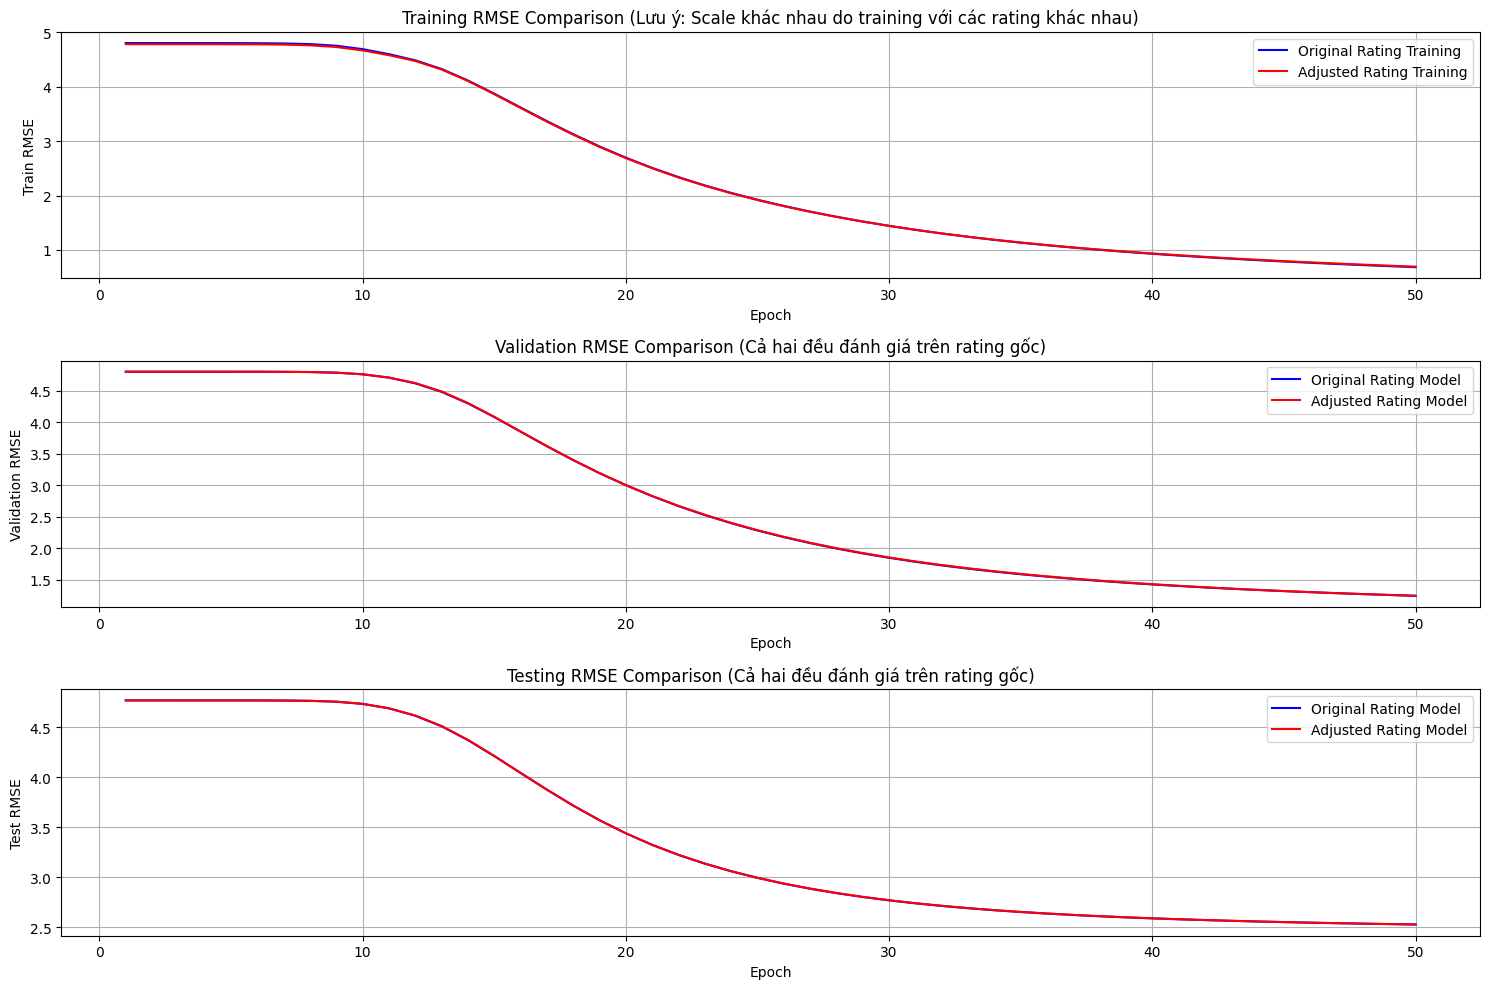


Kết quả cuối cùng:
Original Rating model - Final Validation RMSE: 1.2455
Adjusted Rating (train) model - Final Validation RMSE: 1.2439
Validation Improvement: 0.12%
Original Rating model - Final Test RMSE: 2.5285
Adjusted Rating (train) model - Final Test RMSE: 2.5280
Test Improvement: 0.02%

Lưu ý: Cả hai mô hình đều được đánh giá bằng rating gốc trên tập validation và test,
nhưng mô hình thứ hai được huấn luyện với adjusted_rating trên tập train.

Top 10 products with highest improvement:
     productId  rmse_orig  rmse_adj  improvement  count
335  276642618   0.165682  0.113006    31.793394      7
308     572982   1.146100  0.784035    31.591060      2
138   53703869   2.533680  1.823889    28.014233      2
404  271278938   1.685902  1.442415    14.442526      1
527  275945034   0.900219  0.770253    14.437120      1
74    68774264   1.378282  1.191693    13.537792      2
204   57815506   1.149311  1.000202    12.973782     13
317  157244522   0.931155  0.814351    12.543956      1

In [1676]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Function to prepare data splits (train, validation, test)
def prepare_data_splits(ratings_df, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split the data into train, validation, and test sets by user.

    Parameters:
    -----------
    ratings_df : DataFrame
        DataFrame containing the ratings data
    val_ratio : float
        Proportion of data for validation (default: 0.15)
    test_ratio : float
        Proportion of data for testing (default: 0.15)
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    train_data, val_data, test_data : DataFrames
        The split datasets
    user_to_index, product_to_index : dictionaries
        Mappings from IDs to indices
    """
    # Create mappings for user and product IDs to indices
    user_ids = ratings_df["userId"].unique()
    product_ids = ratings_df["productId"].unique()

    user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
    product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

    # Add index columns
    ratings_df = ratings_df.copy()
    ratings_df["user_idx"] = ratings_df["userId"].map(user_to_index)
    ratings_df["product_idx"] = ratings_df["productId"].map(product_to_index)

    # Split data by user
    train_data = []
    val_data = []
    test_data = []

    # Tính train_ratio từ val_ratio và test_ratio
    train_ratio = 1.0 - val_ratio - test_ratio

    for user_id, group in ratings_df.groupby("userId"):
        # Shuffle the user's ratings
        shuffled_group = group.sample(frac=1, random_state=random_state)

        # Calculate split points bảo đảm chính xác tỷ lệ 70-15-15
        train_split_index = int(len(shuffled_group) * train_ratio)
        val_split_index = int(len(shuffled_group) * (train_ratio + val_ratio))

        # Split the data
        train_data.append(shuffled_group[:train_split_index])
        val_data.append(shuffled_group[train_split_index:val_split_index])
        test_data.append(shuffled_group[val_split_index:])

    # Combine the splits
    train_data = pd.concat(train_data).reset_index(drop=True)
    val_data = pd.concat(val_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)

    # Hiển thị tỷ lệ thực tế
    total = len(ratings_df)
    print(f"Tổng số mẫu: {total}")
    print(f"Train data: {len(train_data)} mẫu ({len(train_data)/total:.2%})")
    print(f"Validation data: {len(val_data)} mẫu ({len(val_data)/total:.2%})")
    print(f"Test data: {len(test_data)} mẫu ({len(test_data)/total:.2%})")

    return train_data, val_data, test_data, user_to_index, product_to_index

# Hàm huấn luyện và đánh giá model
def train_and_evaluate_model(
    train_data,
    val_data,
    test_data,
    rating_column,
    n_users,
    n_products,
    n_factors=20,
    learning_rate=0.005,
    n_epochs=50,
    reg=0.01,
):
    """
    Huấn luyện mô hình Matrix Factorization và đánh giá hiệu suất với tập validation

    Parameters:
    -----------
    train_data, val_data, test_data : DataFrames
        The split datasets
    rating_column : str
        Tên cột chứa rating để sử dụng (rating gốc hoặc đã điều chỉnh)
    n_users, n_products : int
        Number of users and products
    n_factors, learning_rate, n_epochs, reg : Model hyperparameters

    Returns:
    --------
    train_rmse_history, val_rmse_history, test_rmse_history : Lists
        Lịch sử RMSE qua các epochs
    P, Q : np.ndarray
        User and product factor matrices
    """
    # Khởi tạo ma trận yếu tố ẩn
    P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
    Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix

    # Huấn luyện mô hình
    train_rmse_history = []
    val_rmse_history = []
    test_rmse_history = []

    for epoch in range(n_epochs):
        # Huấn luyện trên tập training
        for _, row in train_data.iterrows():
            u = int(row["user_idx"])
            i = int(row["product_idx"])
            r_ui = row[rating_column]

            # Dự đoán rating
            prediction = np.dot(P[u, :], Q[i, :])
            prediction = clip_value(prediction)
            error = r_ui - prediction

            # Cập nhật P và Q sử dụng SGD
            for f in range(n_factors):
                p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
                q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

                # Giới hạn cập nhật để tránh tràn số
                p_update = clip_value(p_update, -0.5, 0.5)
                q_update = clip_value(q_update, -0.5, 0.5)

                P[u, f] += p_update
                Q[i, f] += q_update

        # Tính RMSE trên tập huấn luyện
        train_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in train_data.iterrows()
            ]
        )
        train_rmse = rmse(train_predictions, train_data[rating_column].values)
        train_rmse_history.append(train_rmse)

        # Tính RMSE trên tập validation
        val_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in val_data.iterrows()
            ]
        )
        val_rmse = rmse(val_predictions, val_data[rating_column].values)
        val_rmse_history.append(val_rmse)

        # Tính RMSE trên tập kiểm thử
        test_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in test_data.iterrows()
            ]
        )
        test_rmse = rmse(test_predictions, test_data[rating_column].values)
        test_rmse_history.append(test_rmse)

        print(
            f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Val RMSE: {val_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
        )

    return train_rmse_history, val_rmse_history, test_rmse_history, P, Q


# Hàm để tính RMSE
def rmse(predictions, actual):
    valid_indices = ~np.isnan(predictions)
    if not np.any(valid_indices):
        return float("nan")
    return np.sqrt(np.mean((predictions[valid_indices] - actual[valid_indices]) ** 2))


# Hàm giới hạn giá trị
def clip_value(value, min_val=-5.0, max_val=5.0):
    return max(min_val, min(max_val, value))


# Chuẩn bị dữ liệu
print("Chuẩn bị dữ liệu...")
train_data, val_data, test_data, user_to_index, product_to_index = prepare_data_splits(
    reviews_with_comment, val_ratio=0.15, test_ratio=0.15, random_state=42
)

n_users = len(user_to_index)
n_products = len(product_to_index)

# Giả sử reviews_with_comment là DataFrame chứa cả rating gốc và adjusted_rating
# Đang chạy mô hình với rating gốc
print("Huấn luyện mô hình với rating gốc...")
train_rmse_orig, val_rmse_orig, test_rmse_orig, P_orig, Q_orig = (
    train_and_evaluate_model(
        train_data,
        val_data,
        test_data,
        "rating",
        n_users,
        n_products,
        n_factors=20,
        learning_rate=0.005,
        n_epochs=50,
        reg=0.01,
    )
)

# Chạy mô hình với adjusted_rating chỉ trong tập train, nhưng đánh giá bằng rating gốc trong val và test
print(
    "\nHuấn luyện mô hình với adjusted_rating cho tập train và đánh giá bằng rating gốc..."
)


# Đây là hàm huấn luyện riêng cho trường hợp adjusted_rating chỉ dùng trong train
def train_with_adjusted_evaluate_with_original(
    train_data,
    val_data,
    test_data,
    train_rating_column,
    eval_rating_column,
    n_users,
    n_products,
    n_factors=20,
    learning_rate=0.005,
    n_epochs=50,
    reg=0.01,
):
    """
    Huấn luyện mô hình Matrix Factorization với adjusted_rating cho tập train
    nhưng đánh giá hiệu suất với rating gốc cho val và test
    """
    # Khởi tạo ma trận yếu tố ẩn
    P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
    Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix

    # Huấn luyện mô hình
    train_rmse_history = []
    val_rmse_history = []
    test_rmse_history = []

    for epoch in range(n_epochs):
        # Huấn luyện trên tập training với adjusted_rating
        for _, row in train_data.iterrows():
            u = int(row["user_idx"])
            i = int(row["product_idx"])
            r_ui = row[train_rating_column]  # Sử dụng adjusted_rating cho huấn luyện

            # Dự đoán rating
            prediction = np.dot(P[u, :], Q[i, :])
            prediction = clip_value(prediction)
            error = r_ui - prediction

            # Cập nhật P và Q sử dụng SGD
            for f in range(n_factors):
                p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
                q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

                # Giới hạn cập nhật để tránh tràn số
                p_update = clip_value(p_update, -0.5, 0.5)
                q_update = clip_value(q_update, -0.5, 0.5)

                P[u, f] += p_update
                Q[i, f] += q_update

        # Tính RMSE trên tập huấn luyện với adjusted_rating (để theo dõi quá trình học)
        train_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in train_data.iterrows()
            ]
        )
        train_rmse = rmse(train_predictions, train_data[train_rating_column].values)
        train_rmse_history.append(train_rmse)

        # Tính RMSE trên tập validation với rating gốc
        val_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in val_data.iterrows()
            ]
        )
        val_rmse = rmse(val_predictions, val_data[eval_rating_column].values)
        val_rmse_history.append(val_rmse)

        # Tính RMSE trên tập kiểm thử với rating gốc
        test_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in test_data.iterrows()
            ]
        )
        test_rmse = rmse(test_predictions, test_data[eval_rating_column].values)
        test_rmse_history.append(test_rmse)

        print(
            f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Val RMSE: {val_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
        )

    return train_rmse_history, val_rmse_history, test_rmse_history, P, Q


# Huấn luyện mô hình với adjusted_rating cho tập train, đánh giá bằng rating gốc
train_rmse_adj, val_rmse_adj, test_rmse_adj, P_adj, Q_adj = (
    train_with_adjusted_evaluate_with_original(
        train_data,
        val_data,
        test_data,
        train_rating_column="adjusted_rating",
        eval_rating_column="rating",
        n_users=n_users,
        n_products=n_products,
        n_factors=20,
        learning_rate=0.005,
        n_epochs=50,
        reg=0.01,
    )
)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(15, 10))

# Biểu đồ RMSE train
plt.subplot(3, 1, 1)
plt.plot(
    range(1, len(train_rmse_orig) + 1),
    train_rmse_orig,
    "b-",
    label="Original Rating Training",
)
plt.plot(
    range(1, len(train_rmse_adj) + 1),
    train_rmse_adj,
    "r-",
    label="Adjusted Rating Training",
)
plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title(
    "Training RMSE Comparison (Lưu ý: Scale khác nhau do training với các rating khác nhau)"
)
plt.legend()
plt.grid(True)

# Biểu đồ RMSE validation
plt.subplot(3, 1, 2)
plt.plot(
    range(1, len(val_rmse_orig) + 1), val_rmse_orig, "b-", label="Original Rating Model"
)
plt.plot(
    range(1, len(val_rmse_adj) + 1), val_rmse_adj, "r-", label="Adjusted Rating Model"
)
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Comparison (Cả hai đều đánh giá trên rating gốc)")
plt.legend()
plt.grid(True)

# Biểu đồ RMSE test
plt.subplot(3, 1, 3)
plt.plot(
    range(1, len(test_rmse_orig) + 1),
    test_rmse_orig,
    "b-",
    label="Original Rating Model",
)
plt.plot(
    range(1, len(test_rmse_adj) + 1), test_rmse_adj, "r-", label="Adjusted Rating Model"
)
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Testing RMSE Comparison (Cả hai đều đánh giá trên rating gốc)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("rating_comparison_with_validation.png")
plt.show()

# So sánh RMSE cuối cùng
print("\nKết quả cuối cùng:")
print(f"Original Rating model - Final Validation RMSE: {val_rmse_orig[-1]:.4f}")
print(f"Adjusted Rating (train) model - Final Validation RMSE: {val_rmse_adj[-1]:.4f}")
print(
    f"Validation Improvement: {(val_rmse_orig[-1] - val_rmse_adj[-1]) / val_rmse_orig[-1] * 100:.2f}%"
)

print(f"Original Rating model - Final Test RMSE: {test_rmse_orig[-1]:.4f}")
print(f"Adjusted Rating (train) model - Final Test RMSE: {test_rmse_adj[-1]:.4f}")
print(
    f"Test Improvement: {(test_rmse_orig[-1] - test_rmse_adj[-1]) / test_rmse_orig[-1] * 100:.2f}%"
)
print(
    "\nLưu ý: Cả hai mô hình đều được đánh giá bằng rating gốc trên tập validation và test,"
)
print("nhưng mô hình thứ hai được huấn luyện với adjusted_rating trên tập train.")


# Phân tích mức độ cải thiện theo nhóm sản phẩm (tùy chọn)
def analyze_improvement_by_group(
    test_data, P_orig, Q_orig, P_adj, Q_adj, user_to_index, product_to_index
):
    # Dự đoán cho từng sản phẩm
    improvements = []

    for product_id in test_data["productId"].unique():
        if product_id not in product_to_index:
            continue

        product_idx = product_to_index[product_id]

        # Lấy người dùng đã đánh giá sản phẩm này trong tập test
        users = test_data[test_data["productId"] == product_id]["userId"].unique()
        if len(users) == 0:
            continue

        rmse_orig_sum = 0
        rmse_adj_sum = 0
        count = 0

        for user_id in users:
            if user_id in user_to_index:
                user_idx = user_to_index[user_id]
                actual_rating = test_data[
                    (test_data["userId"] == user_id)
                    & (test_data["productId"] == product_id)
                ]["rating"].values[0]

                pred_orig = clip_value(
                    np.dot(P_orig[user_idx, :], Q_orig[product_idx, :])
                )
                pred_adj = clip_value(np.dot(P_adj[user_idx, :], Q_adj[product_idx, :]))

                error_orig = (pred_orig - actual_rating) ** 2
                error_adj = (pred_adj - actual_rating) ** 2

                rmse_orig_sum += error_orig
                rmse_adj_sum += error_adj
                count += 1

        if count > 0:
            rmse_orig = np.sqrt(rmse_orig_sum / count)
            rmse_adj = np.sqrt(rmse_adj_sum / count)
            improvement = (
                (rmse_orig - rmse_adj) / rmse_orig * 100 if rmse_orig > 0 else 0
            )

            improvements.append(
                {
                    "productId": product_id,
                    "rmse_orig": rmse_orig,
                    "rmse_adj": rmse_adj,
                    "improvement": improvement,
                    "count": count,
                }
            )

    return pd.DataFrame(improvements)


# Uncomment to analyze improvement by product group
product_improvements = analyze_improvement_by_group(
    test_data, P_orig, Q_orig, P_adj, Q_adj, user_to_index, product_to_index
)
print("\nTop 10 products with highest improvement:")
print(product_improvements.sort_values("improvement", ascending=False).head(10))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Function to prepare data splits (train, validation, test)
def prepare_data_splits(ratings_df, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split the data into train, validation, and test sets by user.

    Parameters:
    -----------
    ratings_df : DataFrame
        DataFrame containing the ratings data
    val_ratio : float
        Proportion of data for validation (default: 0.15)
    test_ratio : float
        Proportion of data for testing (default: 0.15)
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    train_data, val_data, test_data : DataFrames
        The split datasets
    user_to_index, product_to_index : dictionaries
        Mappings from IDs to indices
    """
    # Create mappings for user and product IDs to indices
    user_ids = ratings_df["userId"].unique()
    product_ids = ratings_df["productId"].unique()

    user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
    product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

    # Add index columns
    ratings_df = ratings_df.copy()
    ratings_df["user_idx"] = ratings_df["userId"].map(user_to_index)
    ratings_df["product_idx"] = ratings_df["productId"].map(product_to_index)

    # Split data by user
    train_data = []
    val_data = []
    test_data = []

    # Tính train_ratio từ val_ratio và test_ratio
    train_ratio = 1.0 - val_ratio - test_ratio

    for user_id, group in ratings_df.groupby("userId"):
        # Shuffle the user's ratings
        shuffled_group = group.sample(frac=1, random_state=random_state)

        # Calculate split points bảo đảm chính xác tỷ lệ 70-15-15
        train_split_index = int(len(shuffled_group) * train_ratio)
        val_split_index = int(len(shuffled_group) * (train_ratio + val_ratio))

        # Split the data
        train_data.append(shuffled_group[:train_split_index])
        val_data.append(shuffled_group[train_split_index:val_split_index])
        test_data.append(shuffled_group[val_split_index:])

    # Combine the splits
    train_data = pd.concat(train_data).reset_index(drop=True)
    val_data = pd.concat(val_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)

    # Hiển thị tỷ lệ thực tế
    total = len(ratings_df)
    print(f"Tổng số mẫu: {total}")
    print(f"Train data: {len(train_data)} mẫu ({len(train_data)/total:.2%})")
    print(f"Validation data: {len(val_data)} mẫu ({len(val_data)/total:.2%})")
    print(f"Test data: {len(test_data)} mẫu ({len(test_data)/total:.2%})")

    return train_data, val_data, test_data, user_to_index, product_to_index


# Hàm huấn luyện và đánh giá model
def train_and_evaluate_model(
    train_data,
    val_data,
    test_data,
    rating_column,
    n_users,
    n_products,
    n_factors=20,
    learning_rate=0.005,
    n_epochs=50,
    reg=0.01,
):
    """
    Huấn luyện mô hình Matrix Factorization và đánh giá hiệu suất với tập validation

    Parameters:
    -----------
    train_data, val_data, test_data : DataFrames
        The split datasets
    rating_column : str
        Tên cột chứa rating để sử dụng (rating gốc hoặc đã điều chỉnh)
    n_users, n_products : int
        Number of users and products
    n_factors, learning_rate, n_epochs, reg : Model hyperparameters

    Returns:
    --------
    train_rmse_history, val_rmse_history, test_rmse_history : Lists
        Lịch sử RMSE qua các epochs
    P, Q : np.ndarray
        User and product factor matrices
    """
    # Khởi tạo ma trận yếu tố ẩn
    P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
    Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix

    # Huấn luyện mô hình
    train_rmse_history = []
    val_rmse_history = []
    test_rmse_history = []

    for epoch in range(n_epochs):
        # Huấn luyện trên tập training
        for _, row in train_data.iterrows():
            u = int(row["user_idx"])
            i = int(row["product_idx"])
            r_ui = row[rating_column]

            # Dự đoán rating
            prediction = np.dot(P[u, :], Q[i, :])
            prediction = clip_value(prediction)
            error = r_ui - prediction

            # Cập nhật P và Q sử dụng SGD
            for f in range(n_factors):
                p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
                q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

                # Giới hạn cập nhật để tránh tràn số
                p_update = clip_value(p_update, -0.5, 0.5)
                q_update = clip_value(q_update, -0.5, 0.5)

                P[u, f] += p_update
                Q[i, f] += q_update

        # Tính RMSE trên tập huấn luyện
        train_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in train_data.iterrows()
            ]
        )
        train_rmse = rmse(train_predictions, train_data[rating_column].values)
        train_rmse_history.append(train_rmse)

        # Tính RMSE trên tập validation
        val_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in val_data.iterrows()
            ]
        )
        val_rmse = rmse(val_predictions, val_data[rating_column].values)
        val_rmse_history.append(val_rmse)

        # Tính RMSE trên tập kiểm thử
        test_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in test_data.iterrows()
            ]
        )
        test_rmse = rmse(test_predictions, test_data[rating_column].values)
        test_rmse_history.append(test_rmse)

        print(
            f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Val RMSE: {val_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
        )

    return train_rmse_history, val_rmse_history, test_rmse_history, P, Q


# Hàm để tính RMSE
def rmse(predictions, actual):
    valid_indices = ~np.isnan(predictions)
    if not np.any(valid_indices):
        return float("nan")
    return np.sqrt(np.mean((predictions[valid_indices] - actual[valid_indices]) ** 2))


# Hàm giới hạn giá trị
def clip_value(value, min_val=-5.0, max_val=5.0):
    return max(min_val, min(max_val, value))


# Chuẩn bị dữ liệu
print("Chuẩn bị dữ liệu...")
train_data, val_data, test_data, user_to_index, product_to_index = prepare_data_splits(
    reviews_with_comment, val_ratio=0.15, test_ratio=0.15, random_state=42
)

n_users = len(user_to_index)
n_products = len(product_to_index)

# Giả sử reviews_with_comment là DataFrame chứa cả rating gốc và adjusted_rating
# Đang chạy mô hình với rating gốc
print("Huấn luyện mô hình với rating gốc...")
train_rmse_orig, val_rmse_orig, test_rmse_orig, P_orig, Q_orig = (
    train_and_evaluate_model(
        train_data,
        val_data,
        test_data,
        "rating",
        n_users,
        n_products,
        n_factors=20,
        learning_rate=0.005,
        n_epochs=50,
        reg=0.01,
    )
)

# Chạy mô hình với adjusted_rating chỉ trong tập train, nhưng đánh giá bằng rating gốc trong val và test
print(
    "\nHuấn luyện mô hình với adjusted_rating cho tập train và đánh giá bằng rating gốc..."
)


# Đây là hàm huấn luyện riêng cho trường hợp adjusted_rating chỉ dùng trong train
def train_with_adjusted_evaluate_with_original(
    train_data,
    val_data,
    test_data,
    train_rating_column,
    eval_rating_column,
    n_users,
    n_products,
    n_factors=20,
    learning_rate=0.005,
    n_epochs=50,
    reg=0.01,
):
    """
    Huấn luyện mô hình Matrix Factorization với adjusted_rating cho tập train
    nhưng đánh giá hiệu suất với rating gốc cho val và test
    """
    # Khởi tạo ma trận yếu tố ẩn
    P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
    Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix

    # Huấn luyện mô hình
    train_rmse_history = []
    val_rmse_history = []
    test_rmse_history = []

    for epoch in range(n_epochs):
        # Huấn luyện trên tập training với adjusted_rating
        for _, row in train_data.iterrows():
            u = int(row["user_idx"])
            i = int(row["product_idx"])
            r_ui = row[train_rating_column]  # Sử dụng adjusted_rating cho huấn luyện

            # Dự đoán rating
            prediction = np.dot(P[u, :], Q[i, :])
            prediction = clip_value(prediction)
            error = r_ui - prediction

            # Cập nhật P và Q sử dụng SGD
            for f in range(n_factors):
                p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
                q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

                # Giới hạn cập nhật để tránh tràn số
                p_update = clip_value(p_update, -0.5, 0.5)
                q_update = clip_value(q_update, -0.5, 0.5)

                P[u, f] += p_update
                Q[i, f] += q_update

        # Tính RMSE trên tập huấn luyện với adjusted_rating (để theo dõi quá trình học)
        train_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in train_data.iterrows()
            ]
        )
        train_rmse = rmse(train_predictions, train_data[train_rating_column].values)
        train_rmse_history.append(train_rmse)

        # Tính RMSE trên tập validation với rating gốc
        val_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in val_data.iterrows()
            ]
        )
        val_rmse = rmse(val_predictions, val_data[eval_rating_column].values)
        val_rmse_history.append(val_rmse)

        # Tính RMSE trên tập kiểm thử với rating gốc
        test_predictions = np.array(
            [
                clip_value(
                    np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
                )
                for _, row in test_data.iterrows()
            ]
        )
        test_rmse = rmse(test_predictions, test_data[eval_rating_column].values)
        test_rmse_history.append(test_rmse)

        print(
            f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Val RMSE: {val_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
        )

    return train_rmse_history, val_rmse_history, test_rmse_history, P, Q


# Huấn luyện mô hình với adjusted_rating cho tập train, đánh giá bằng rating gốc
train_rmse_adj, val_rmse_adj, test_rmse_adj, P_adj, Q_adj = (
    train_with_adjusted_evaluate_with_original(
        train_data,
        val_data,
        test_data,
        train_rating_column="adjusted_rating",
        eval_rating_column="rating",
        n_users=n_users,
        n_products=n_products,
        n_factors=20,
        learning_rate=0.005,
        n_epochs=100,
        reg=0.01,
    )
)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(15, 10))

# Biểu đồ RMSE train
plt.subplot(3, 1, 1)
plt.plot(
    range(1, len(train_rmse_orig) + 1),
    train_rmse_orig,
    "b-",
    label="Original Rating Training",
)
plt.plot(
    range(1, len(train_rmse_adj) + 1),
    train_rmse_adj,
    "r-",
    label="Adjusted Rating Training",
)
plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title(
    "Training RMSE Comparison (Lưu ý: Scale khác nhau do training với các rating khác nhau)"
)
plt.legend()
plt.grid(True)

# Biểu đồ RMSE validation
plt.subplot(3, 1, 2)
plt.plot(
    range(1, len(val_rmse_orig) + 1), val_rmse_orig, "b-", label="Original Rating Model"
)
plt.plot(
    range(1, len(val_rmse_adj) + 1), val_rmse_adj, "r-", label="Adjusted Rating Model"
)
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Comparison (Cả hai đều đánh giá trên rating gốc)")
plt.legend()
plt.grid(True)

# Biểu đồ RMSE test
plt.subplot(3, 1, 3)
plt.plot(
    range(1, len(test_rmse_orig) + 1),
    test_rmse_orig,
    "b-",
    label="Original Rating Model",
)
plt.plot(
    range(1, len(test_rmse_adj) + 1), test_rmse_adj, "r-", label="Adjusted Rating Model"
)
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Testing RMSE Comparison (Cả hai đều đánh giá trên rating gốc)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("rating_comparison_with_validation.png")
plt.show()

# So sánh RMSE cuối cùng
print("\nKết quả cuối cùng:")
print(f"Original Rating model - Final Validation RMSE: {val_rmse_orig[-1]:.4f}")
print(f"Adjusted Rating (train) model - Final Validation RMSE: {val_rmse_adj[-1]:.4f}")
print(
    f"Validation Improvement: {(val_rmse_orig[-1] - val_rmse_adj[-1]) / val_rmse_orig[-1] * 100:.2f}%"
)

print(f"Original Rating model - Final Test RMSE: {test_rmse_orig[-1]:.4f}")
print(f"Adjusted Rating (train) model - Final Test RMSE: {test_rmse_adj[-1]:.4f}")
print(
    f"Test Improvement: {(test_rmse_orig[-1] - test_rmse_adj[-1]) / test_rmse_orig[-1] * 100:.2f}%"
)
print(
    "\nLưu ý: Cả hai mô hình đều được đánh giá bằng rating gốc trên tập validation và test,"
)
print("nhưng mô hình thứ hai được huấn luyện với adjusted_rating trên tập train.")


# Phân tích mức độ cải thiện theo nhóm sản phẩm (tùy chọn)
def analyze_improvement_by_group(
    test_data, P_orig, Q_orig, P_adj, Q_adj, user_to_index, product_to_index
):
    # Dự đoán cho từng sản phẩm
    improvements = []

    for product_id in test_data["productId"].unique():
        if product_id not in product_to_index:
            continue

        product_idx = product_to_index[product_id]

        # Lấy người dùng đã đánh giá sản phẩm này trong tập test
        users = test_data[test_data["productId"] == product_id]["userId"].unique()
        if len(users) == 0:
            continue

        rmse_orig_sum = 0
        rmse_adj_sum = 0
        count = 0

        for user_id in users:
            if user_id in user_to_index:
                user_idx = user_to_index[user_id]
                actual_rating = test_data[
                    (test_data["userId"] == user_id)
                    & (test_data["productId"] == product_id)
                ]["rating"].values[0]

                pred_orig = clip_value(
                    np.dot(P_orig[user_idx, :], Q_orig[product_idx, :])
                )
                pred_adj = clip_value(np.dot(P_adj[user_idx, :], Q_adj[product_idx, :]))

                error_orig = (pred_orig - actual_rating) ** 2
                error_adj = (pred_adj - actual_rating) ** 2

                rmse_orig_sum += error_orig
                rmse_adj_sum += error_adj
                count += 1

        if count > 0:
            rmse_orig = np.sqrt(rmse_orig_sum / count)
            rmse_adj = np.sqrt(rmse_adj_sum / count)
            improvement = (
                (rmse_orig - rmse_adj) / rmse_orig * 100 if rmse_orig > 0 else 0
            )

            improvements.append(
                {
                    "productId": product_id,
                    "rmse_orig": rmse_orig,
                    "rmse_adj": rmse_adj,
                    "improvement": improvement,
                    "count": count,
                }
            )

    return pd.DataFrame(improvements)


# Uncomment to analyze improvement by product group
product_improvements = analyze_improvement_by_group(
    test_data, P_orig, Q_orig, P_adj, Q_adj, user_to_index, product_to_index
)
print("\nTop 10 products with highest improvement:")
print(product_improvements.sort_values("improvement", ascending=False).head(10))

### Tiki 45k reviews

In [ ]:
import datetime
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read data from CSV file
data = pd.read_csv("../02.Dataset/reviews_45k.csv", encoding="utf-8")

# Get necessary columns
ratings = data[
    ["ProductID", "CustomerID", "Rating"]
].copy()  # Create a copy to avoid warnings

# Convert ProductID and CustomerID to integer indices
user_ids = ratings["CustomerID"].unique()
product_ids = ratings["ProductID"].unique()

user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

ratings["user_idx"] = ratings["CustomerID"].map(user_to_index)
ratings["product_idx"] = ratings["ProductID"].map(product_to_index)

train_data = []
test_data = []

for user_id, group in ratings.groupby("CustomerID"):
    # Shuffle the ratings of each user and split into train and test
    shuffled_group = group.sample(frac=1, random_state=42)  # Shuffle the group
    split_index = int(len(shuffled_group) * 0.8)  # 80% for training, 20% for testing
    train_data.append(shuffled_group[:split_index])
    test_data.append(shuffled_group[split_index:])

# Combine the train and test data into separate DataFrames
train_data = pd.concat(train_data).reset_index(drop=True)
test_data = pd.concat(test_data).reset_index(drop=True)

# Split data into training and test sets
# train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Initialize parameters
n_users = len(user_ids)
n_products = len(product_ids)
n_factors = 20  # Number of latent factors
learning_rate = 0.005  # Reduced learning rate to prevent overflow
n_epochs = 50  # Number of iterations
reg = 0.01  # Regularization parameter

# Initialize latent factor matrices for users and products
# Use smaller initial values to prevent overflow
P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix


# Function to calculate RMSE
def rmse(predictions, actual):
    # Filter out any NaN values
    valid_indices = ~np.isnan(predictions)
    if not np.any(valid_indices):
        return float("nan")
    return np.sqrt(np.mean((predictions[valid_indices] - actual[valid_indices]) ** 2))


# Function to clip values to prevent overflow
def clip_value(value, min_val=-5.0, max_val=5.0):
    return max(min_val, min(max_val, value))


# Train the model with SGD
train_rmse_history = []
test_rmse_history = []

for epoch in range(n_epochs):
    # Train on training set
    for _, row in train_data.iterrows():
        u = int(row["user_idx"])
        i = int(row["product_idx"])
        r_ui = row["Rating"]

        # Predict rating
        prediction = np.dot(P[u, :], Q[i, :])
        # Clip prediction to prevent extreme values
        prediction = clip_value(prediction)
        error = r_ui - prediction

        # Update P and Q using SGD with gradient clipping
        for f in range(n_factors):
            p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
            q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

            # Clip updates to prevent overflow
            p_update = clip_value(p_update, -0.5, 0.5)
            q_update = clip_value(q_update, -0.5, 0.5)

            P[u, f] += p_update
            Q[i, f] += q_update

    # Calculate RMSE on training set
    train_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in train_data.iterrows()
        ]
    )
    train_rmse = rmse(train_predictions, train_data["Rating"].values)
    train_rmse_history.append(train_rmse)

    # Calculate RMSE on test set
    test_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in test_data.iterrows()
        ]
    )
    test_rmse = rmse(test_predictions, test_data["Rating"].values)
    test_rmse_history.append(test_rmse)

    print(
        f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
    )

# Save the model
model_data = {
    "P": P,
    "Q": Q,
    "user_to_index": user_to_index,
    "product_to_index": product_to_index,
    "train_rmse_history": train_rmse_history,
    "test_rmse_history": test_rmse_history,
}

with open("../05.Models/mf_45k_model.pkl", "wb") as f:
    pickle.dump(model_data, f)
print("Model saved to mf_model.pkl")

# Save log
log_df = pd.DataFrame(
    {
        "epoch": range(1, n_epochs + 1),
        "train_rmse": train_rmse_history,
        "test_rmse": test_rmse_history,
    }
)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_df.to_csv(f"../06.Log/train_mf_45k_log_{timestamp}.csv", index=False, encoding="utf-8")
print("Training log saved to train_mf_log_{timestamp}.csv")


# Function to predict rating for a user-product pair
def predict_rating(user_id, product_id):
    if user_id not in user_to_index or product_id not in product_to_index:
        return None  # If user or product is not in the data
    u = user_to_index[user_id]
    i = product_to_index[product_id]
    # Clip prediction to avoid extreme values
    u = user_to_index[user_id]
    i = product_to_index[product_id]
    prediction = np.dot(P[u, :], Q[i, :])
    return clip_value(prediction)


# Example prediction
user_id_example = 18387707  # An example CustomerID
product_id_example = 192733741  # An example ProductID
predicted_rating = predict_rating(user_id_example, product_id_example)
if predicted_rating is not None:
    print(
        f"Predicted rating for User {user_id_example} and Product {product_id_example}: {predicted_rating:.2f}"
    )
else:
    print(
        f"Unable to predict for User {user_id_example} and Product {product_id_example} (not in training data)"
    )

# Plot RMSE graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_rmse_history, label="Train RMSE")
plt.plot(range(1, n_epochs + 1), test_rmse_history, label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Matrix Factorization Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

### Tiki 300k reviews

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read data from CSV file
data = pd.read_csv("../02.Dataset/reviews_300k.csv", encoding="utf-8")

# Get necessary columns
ratings = data[
    ["userId", "productId", "rating"]
].copy()  # Create a copy to avoid warnings

# Convert ProductID and CustomerID to integer indices
user_ids = ratings["userId"].unique()
product_ids = ratings["productId"].unique()

user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

ratings["user_idx"] = ratings["userId"].map(user_to_index)
ratings["product_idx"] = ratings["productId"].map(product_to_index)

train_data = []
test_data = []

for user_id, group in ratings.groupby("userId"):
    # Shuffle the ratings of each user and split into train and test
    shuffled_group = group.sample(frac=1, random_state=42)  # Shuffle the group
    split_index = int(len(shuffled_group) * 0.8)  # 80% for training, 20% for testing
    train_data.append(shuffled_group[:split_index])
    test_data.append(shuffled_group[split_index:])

# Combine the train and test data into separate DataFrames
train_data = pd.concat(train_data).reset_index(drop=True)
test_data = pd.concat(test_data).reset_index(drop=True)

# Split data into training and test sets
# train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Initialize parameters
n_users = len(user_ids)
n_products = len(product_ids)
n_factors = 20  # Number of latent factors
learning_rate = 0.005  # Reduced learning rate to prevent overflow
n_epochs = 50  # Number of iterations
reg = 0.01  # Regularization parameter

# Initialize latent factor matrices for users and products
# Use smaller initial values to prevent overflow
P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix


# Function to calculate RMSE
def rmse(predictions, actual):
    # Filter out any NaN values
    valid_indices = ~np.isnan(predictions)
    if not np.any(valid_indices):
        return float("nan")
    return np.sqrt(np.mean((predictions[valid_indices] - actual[valid_indices]) ** 2))


# Function to clip values to prevent overflow
def clip_value(value, min_val=-5.0, max_val=5.0):
    return max(min_val, min(max_val, value))


# Train the model with SGD
train_rmse_history = []
test_rmse_history = []

for epoch in range(n_epochs):
    # Train on training set
    for _, row in train_data.iterrows():
        u = int(row["user_idx"])
        i = int(row["product_idx"])
        r_ui = row["rating"]

        # Predict rating
        prediction = np.dot(P[u, :], Q[i, :])
        # Clip prediction to prevent extreme values
        prediction = clip_value(prediction)
        error = r_ui - prediction

        # Update P and Q using SGD with gradient clipping
        for f in range(n_factors):
            p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
            q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

            # Clip updates to prevent overflow
            p_update = clip_value(p_update, -0.5, 0.5)
            q_update = clip_value(q_update, -0.5, 0.5)

            P[u, f] += p_update
            Q[i, f] += q_update

    # Calculate RMSE on training set
    train_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in train_data.iterrows()
        ]
    )
    train_rmse = rmse(train_predictions, train_data["rating"].values)
    train_rmse_history.append(train_rmse)

    # Calculate RMSE on test set
    test_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in test_data.iterrows()
        ]
    )
    test_rmse = rmse(test_predictions, test_data["rating"].values)
    test_rmse_history.append(test_rmse)

    print(
        f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
    )

# Save the model
model_data = {
    "P": P,
    "Q": Q,
    "user_to_index": user_to_index,
    "product_to_index": product_to_index,
    "train_rmse_history": train_rmse_history,
    "test_rmse_history": test_rmse_history,
}

with open("../05.Models/mf_300k_model.pkl", "wb") as f:
    pickle.dump(model_data, f)
print("Model saved to mf_300k_model.pkl")

# Save log
log_df = pd.DataFrame(
    {
        "epoch": range(1, n_epochs + 1),
        "train_rmse": train_rmse_history,
        "test_rmse": test_rmse_history,
    }
)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_df.to_csv(
    f"../06.Log/train_mf_300k_log_{timestamp}.csv", index=False, encoding="utf-8"
)
print("Training log saved to train_mf_300k_log_{timestamp}.csv")

# Function to predict rating for a user-product pair
def predict_rating(user_id, product_id):
    if user_id not in user_to_index or product_id not in product_to_index:
        return None  # If user or product is not in the data
    u = user_to_index[user_id]
    i = product_to_index[product_id]
    # Clip prediction to avoid extreme values
    return clip_value(np.dot(P[u, :], Q[i, :]))


# Example prediction
user_id_example = 18387707  # An example CustomerID
product_id_example = 192733741  # An example ProductID
predicted_rating = predict_rating(user_id_example, product_id_example)
if predicted_rating is not None:
    print(
        f"Predicted rating for User {user_id_example} and Product {product_id_example}: {predicted_rating:.2f}"
    )
else:
    print(
        f"Unable to predict for User {user_id_example} and Product {product_id_example} (not in training data)"
    )

# Plot RMSE graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_rmse_history, label="Train RMSE")
plt.plot(range(1, n_epochs + 1), test_rmse_history, label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Matrix Factorization Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

### Movielens 1M

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read data from CSV file
data = pd.read_csv(
    "../02.Dataset/movielens/ratings.dat",
    sep="::",
    engine="python",
    names=["UserID", "MovieID", "Rating", "Timestamp"],
)

# Get necessary columns
ratings = data[
    ["UserID", "MovieID", "Rating"]
].copy()  # Create a copy to avoid warnings

# Convert MovieID and CustomerID to integer indices
user_ids = ratings["UserID"].unique()
product_ids = ratings["MovieID"].unique()

user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

ratings["user_idx"] = ratings["UserID"].map(user_to_index)
ratings["product_idx"] = ratings["MovieID"].map(product_to_index)

train_data = []
test_data = []

for user_id, group in ratings.groupby("UserID"):
    # Shuffle the ratings of each user and split into train and test
    shuffled_group = group.sample(frac=1, random_state=42)  # Shuffle the group
    split_index = int(len(shuffled_group) * 0.8)  # 80% for training, 20% for testing
    train_data.append(shuffled_group[:split_index])
    test_data.append(shuffled_group[split_index:])

# Combine the train and test data into separate DataFrames
train_data = pd.concat(train_data).reset_index(drop=True)
test_data = pd.concat(test_data).reset_index(drop=True)

# Split data into training and test sets
# train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Initialize parameters
n_users = len(user_ids)
n_products = len(product_ids)
n_factors = 20  # Number of latent factors
learning_rate = 0.005  # Reduced learning rate to prevent overflow
n_epochs = 50  # Number of iterations
reg = 0.01  # Regularization parameter

# Initialize latent factor matrices for users and products
# Use smaller initial values to prevent overflow
P = np.random.normal(0, 0.01, (n_users, n_factors))  # User matrix
Q = np.random.normal(0, 0.01, (n_products, n_factors))  # Product matrix


# Function to calculate RMSE
def rmse(predictions, actual):
    # Filter out any NaN values
    valid_indices = ~np.isnan(predictions)
    if not np.any(valid_indices):
        return float("nan")
    return np.sqrt(np.mean((predictions[valid_indices] - actual[valid_indices]) ** 2))


# Function to clip values to prevent overflow
def clip_value(value, min_val=-5.0, max_val=5.0):
    return max(min_val, min(max_val, value))


# Train the model with SGD
train_rmse_history = []
test_rmse_history = []

for epoch in range(n_epochs):
    # Train on training set
    for _, row in train_data.iterrows():
        u = int(row["user_idx"])
        i = int(row["product_idx"])
        r_ui = row["Rating"]

        # Predict rating
        prediction = np.dot(P[u, :], Q[i, :])
        # Clip prediction to prevent extreme values
        prediction = clip_value(prediction)
        error = r_ui - prediction

        # Update P and Q using SGD with gradient clipping
        for f in range(n_factors):
            p_update = learning_rate * (error * Q[i, f] - reg * P[u, f])
            q_update = learning_rate * (error * P[u, f] - reg * Q[i, f])

            # Clip updates to prevent overflow
            p_update = clip_value(p_update, -0.5, 0.5)
            q_update = clip_value(q_update, -0.5, 0.5)

            P[u, f] += p_update
            Q[i, f] += q_update

    # Calculate RMSE on training set
    train_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in train_data.iterrows()
        ]
    )
    train_rmse = rmse(train_predictions, train_data["Rating"].values)
    train_rmse_history.append(train_rmse)

    # Calculate RMSE on test set
    test_predictions = np.array(
        [
            clip_value(
                np.dot(P[int(row["user_idx"]), :], Q[int(row["product_idx"]), :])
            )
            for _, row in test_data.iterrows()
        ]
    )
    test_rmse = rmse(test_predictions, test_data["Rating"].values)
    test_rmse_history.append(test_rmse)

    print(
        f"Epoch {epoch + 1}/{n_epochs} - Train RMSE: {train_rmse:.4f} - Test RMSE: {test_rmse:.4f}"
    )

# Save the model
model_data = {
    "P": P,
    "Q": Q,
    "user_to_index": user_to_index,
    "product_to_index": product_to_index,
    "train_rmse_history": train_rmse_history,
    "test_rmse_history": test_rmse_history,
}

with open("../05.Models/mf_movielens_1m_model.pkl", "wb") as f:
    pickle.dump(model_data, f)
print("Model saved to mf_movielens_1m_model.pkl")

# Save log
log_df = pd.DataFrame(
    {
        "epoch": range(1, n_epochs + 1),
        "train_rmse": train_rmse_history,
        "test_rmse": test_rmse_history,
    }
)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_df.to_csv(
    f"../06.Log/train_mf_movielens_log_{timestamp}.csv", index=False, encoding="utf-8"
)
print("Training log saved to train_mf_movielens_1m_log_{timestamp}.csv")


# Function to predict rating for a user-product pair
def predict_rating(user_id, product_id):
    if user_id not in user_to_index or product_id not in product_to_index:
        return None  # If user or product is not in the data
    u = user_to_index[user_id]
    i = product_to_index[product_id]
    # Clip prediction to avoid extreme values
    return clip_value(np.dot(P[u, :], Q[i, :]))

# Plot RMSE graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_rmse_history, label="Train RMSE")
plt.plot(range(1, n_epochs + 1), test_rmse_history, label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Matrix Factorization Learning Curve")
plt.legend()
plt.grid(True)
plt.show()